In [40]:
!pip install gymnasium[classic_control] renderlab

In [41]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np


env = gym.make('Acrobot-v1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [42]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

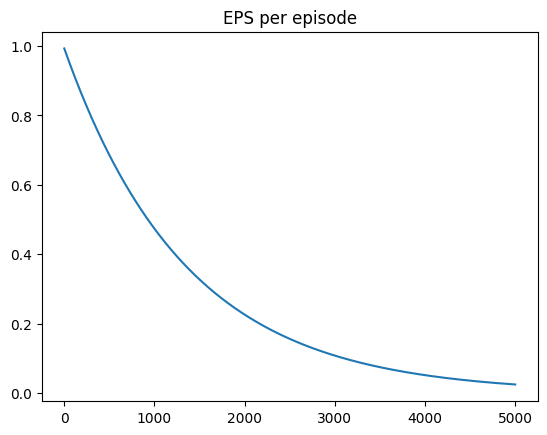

In [43]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.99
EPS_END = 0.005
TAU = 0.2
LR = 1e-5
REPLAY_MEM = 10000
NUM_EPISODES = 5000

powspace = lambda s, e, n, k: np.logspace(np.log(s), np.log(e), n, base=np.exp(k))

eps_per_episode = powspace(EPS_START, EPS_END, NUM_EPISODES, 0.7)

plt.figure()
plt.title('EPS per episode')
plt.plot(eps_per_episode)

In [44]:
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

print(n_actions)
print(n_observations)

3
6


In [45]:
def select_action(state, i):
    if random.random() > eps_per_episode[i]:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [46]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')


    plt.plot(durations_t.numpy(), label="Episode rewards")
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.full((99, ), np.nan), means))
        plt.plot(means.numpy(), label='Mean 100 rewards')

    plt.grid()
    plt.ylim(-500, 100)
    plt.xticks(np.arange(0, NUM_EPISODES+1, step=100), rotation=90)
    plt.yticks(np.arange(-500, 100+1, step=50))
    plt.legend()

    #plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)

In [47]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [48]:
def train_model():
    n_terminated = 0

    for i_episode in range(NUM_EPISODES):
        # Initialize the environment and get it's state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward = 0

        for t in count():
            action = select_action(state, i_episode)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            episode_reward += reward
            n_terminated += int(terminated)

            reward = torch.tensor([reward], device=device)
            done = terminated or truncated


            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                if i_episode % 20 == 0:
                  plot_durations()
                episode_rewards.append(episode_reward)
                break

In [49]:
import renderlab as rl

def render_sample():
    env = gym.make("Acrobot-v1", render_mode = "rgb_array")
    env = rl.RenderFrame(env, "./output")

    observation, info = env.reset()
    observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    while True:
      with torch.no_grad():
          action = policy_net(observation).max(1).indices.view(1, 1)
      observation, reward, terminated, truncated, _ = env.step(action.item())
      observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
      done = terminated or truncated

      if done:
        break

    env.play()

In [50]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(512, n_actions)

    def forward(self, x):

        x = F.leaky_relu(self.layer1(x))
        x = F.leaky_relu(self.layer2(x))
        return self.layer3(x)

In [51]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(REPLAY_MEM)
episode_rewards = []

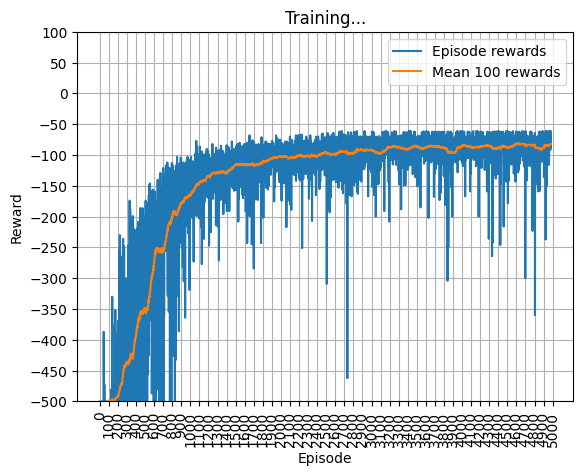

In [52]:
train_model()

In [53]:
torch.save(policy_net, 'policy_net_1000.pth')

In [54]:
policy_net.eval()

DQN(
  (layer1): Linear(in_features=6, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=3, bias=True)
)

In [55]:
DQN_REWARDS = episode_rewards.copy()

In [56]:
render_sample()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


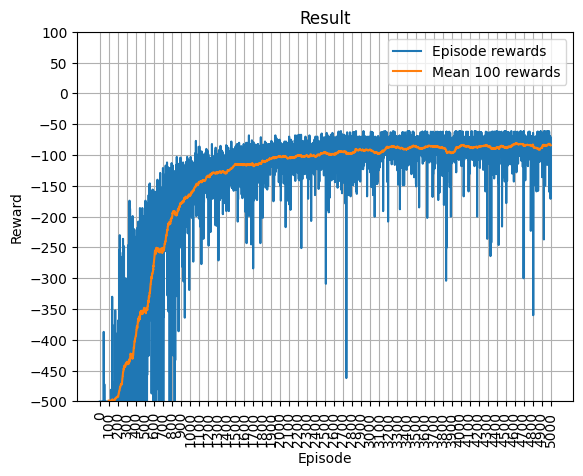

In [57]:
plot_durations(True)

In [58]:
class DuelingDQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DuelingDQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 512)
        self.value_stream = nn.Linear(512, 1)
        self.advantage_stream = nn.Linear(512, n_actions)


    def forward(self, x):
        x = F.leaky_relu(self.layer1(x))
        x = F.leaky_relu(self.layer2(x))

        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))

        return q_values

In [59]:
policy_net = DuelingDQN(n_observations, n_actions).to(device)
target_net = DuelingDQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(REPLAY_MEM)

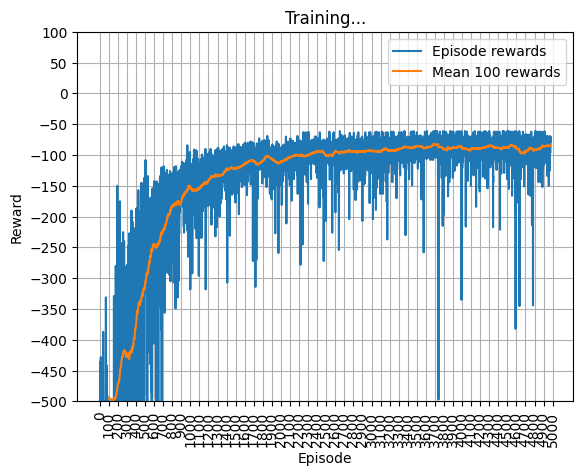

In [60]:
episode_rewards = []

train_model()

In [61]:
torch.save(policy_net, 'policy_net_dueling_1000.pth')

In [62]:
DUELING_REWARDS = episode_rewards.copy()

In [63]:
render_sample()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


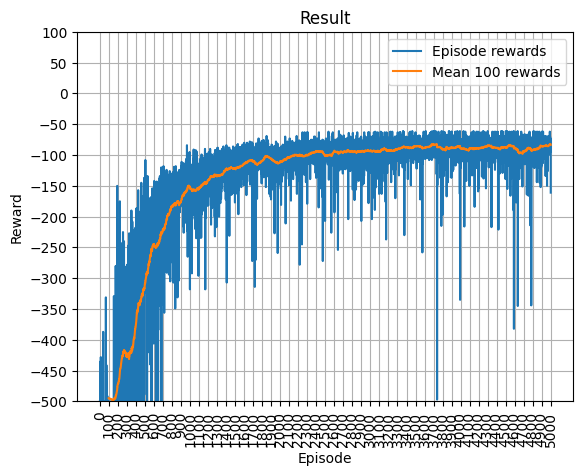

In [64]:
plot_durations(True)

In [65]:
from scipy.stats import kstest
kstest(DQN_REWARDS, DUELING_REWARDS)

KstestResult(statistic=0.028, pvalue=0.039677110232779096, statistic_location=-72.0, statistic_sign=-1)